In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from config_images import *
import matplotlib.gridspec as gridspec

In [2]:
#save_path = "/home/rodrigo/supernovae_detection/simulated_data/image_sequences/"
save_path = "../../datasets/simulated_data/image_sequences/ztf_positive_psf_ztf_positive_psf10"
f = h5py.File(save_path+".hdf5", "r")
fields = list(f.keys())
#stats = np.load("/home/toshiba/rodrigo/simulated_lightcurves/multiclass_SNLS_short20000.pkl")

In [3]:
list(f.keys()) # ['Field01', 'Field02', 'Field03', 'Field04' ...]
list(f["Field01"].keys())
"""['count_lightcurves',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']"""
data_keys = ['count_lightcurves',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']
list(f["Field01"]["images"].keys())

['g', 'r']

In [4]:
list(f["Field01"].keys())

['count_lightcurves',
 'estimated_counts',
 'estimated_error_counts',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']

In [5]:
f["Field01"]['lightcurves']['g'][0]

array([18.747095, 18.924677, 18.668983, 18.643036, 18.681232, 18.946861,
       18.60996 , 18.74836 , 18.780207, 18.870176, 18.792713],
      dtype=float32)

In [6]:
f["Field01"]['estimated_counts']['g']

<HDF5 dataset "g": shape (60, 11), type "<f8">

In [7]:
def print_shape(f, data_keys, n_fields = 5, bands = ["g", "r"]):
    fields = list(f.keys())
    for field in fields[:n_fields]:
        print("Field", field)
        #data_keys = list(f[field].keys())
        for k in data_keys:
            for b in bands:
                print("key:",k," band:", b)
                if k not in ["galaxy_flag", "ids", "labels", "lc_type", "obs_cond"]:
                    print(f[field][k][b].shape)
                elif k == "obs_cond":
                    k_keys = list(f[field][k].keys())
                    for k_obs in k_keys:
                        if k_obs in ["filter", "limmag3"]:
                            continue
                        print("obs_cond", k_obs)
                        print(f[field][k][k_obs][b].shape)
                else:
                    print(f[field][k].shape)
print_shape(f, data_keys)

Field Field01
key: count_lightcurves  band: g
(60, 11)
key: count_lightcurves  band: r
(60, 12)
key: galaxy_flag  band: g
(60,)
key: galaxy_flag  band: r
(60,)
key: galaxy_image  band: g
(60, 21, 21, 11)
key: galaxy_image  band: r
(60, 21, 21, 12)
key: ids  band: g
(60,)
key: ids  band: r
(60,)
key: images  band: g
(60, 21, 21, 11)
key: images  band: r
(60, 21, 21, 12)
key: labels  band: g
(60,)
key: labels  band: r
(60,)
key: lc_type  band: g
(60,)
key: lc_type  band: r
(60,)
key: lightcurves  band: g
(60, 11)
key: lightcurves  band: r
(60, 12)
key: obs_cond  band: g
obs_cond airmass
(11,)
obs_cond epoch
(11,)
obs_cond exp_time
(11,)
obs_cond flux_conversion
(11,)
obs_cond good_quality_points
(11,)
obs_cond limmag5
(11,)
obs_cond obs_day
(11,)
obs_cond seeing
(11,)
obs_cond sky_brightness
(11,)
obs_cond zero_point
(11,)
key: obs_cond  band: r
obs_cond airmass
(12,)
obs_cond epoch
(12,)
obs_cond exp_time
(12,)
obs_cond flux_conversion
(12,)
obs_cond good_quality_points
(12,)
obs_cond l

In [109]:
estimated_counts_key = 'estimated_counts'
estimated_error_counts_key = 'estimated_error_counts'
g_key = 'g'
r_key = 'r'
lightcurves_key = 'lightcurves'

def get_magnitude_error(estimated_counts, estimated_count_error):
  f = estimated_counts
  sigma_f = np.sqrt(estimated_count_error)
  sigma_m = 1.09 * (sigma_f / f)
  return sigma_m

def get_magnitude(ADU, zp, T):
  magnitude = zp - 2.5 * np.log10(ADU / T)
  #if np.isnan(magnitude).any():
  #  print("ADU %s\nT %s\nADU/T %s\nlog %s"
  #        % (str(ADU), str(T), str(ADU / T), str(np.log10(ADU / T))))
  return magnitude

def _silent_plot_lc(ax, field_data, lc_idx, plt_marker='o-'):
  field_lc = field_data[lightcurves_key]
  estimated_counts = field_data[estimated_counts_key]
  estimated_error_counts = field_data[estimated_error_counts_key]
  days = field_data["obs_cond"]["obs_day"]
  bands = list(field_data[lightcurves_key].keys())
  colors = ['y', 'r']
  for i, band in enumerate(bands):
    magnitude_noisy = get_magnitude(estimated_counts[band][lc_idx], 24.5, 30)
    magnitude_error = get_magnitude_error(estimated_counts[band][lc_idx],
                                          estimated_error_counts[band][lc_idx])
    # print(estimated_counts[band][lc_idx].shape)
    # print(magnitude_error)
    # print(days[band])
    # print(magnitude_noisy)
    #c
    ax.plot(days[band], field_lc[band][lc_idx], '%s%s'%(colors[i],plt_marker), label='%s; model' % band)#,
        #color=color)
    color = ax.get_lines()[i * 2].get_color()
    ax.errorbar(days[band][:], magnitude_noisy, yerr=magnitude_error, fmt='o--',
                label='%s; lightcurve' % band, color=color)
    ax.set_ylim([21, 15])
    #plt.gca().invert_yaxis()

  ax.legend()
  galaxy_flag = field_data["galaxy_flag"][lc_idx]
  lc_type = field_data["lc_type"][lc_idx]
  ax.set_title("%s; galaxy_flag: %i" % (lc_type, galaxy_flag), fontsize=15)
  return ax


def _get_field(data, field):
  if field is None:
    fields = list(data.keys())
    field = fields[int(np.random.choice(np.arange(len(fields)), 1, replace=False))]
    return field
  else:
    return field

def plot_underliying_and_lc_model(data, field=None, n_to_plot=1):
    field = _get_field(data, field)
    field_data = data[field]
    lc_idxs_to_plot = np.random.choice(np.arange(field_data[lightcurves_key][g_key].shape[0]), n_to_plot, replace=False) #[13]
    print('%s%s' % (field, str(lc_idxs_to_plot)))
    plt.close()
    for lc_idx in lc_idxs_to_plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
        _silent_plot_lc(ax, field_data, lc_idx)
        
        #plt.close()
    plt.show()
    return lc_idxs_to_plot[0]


Field01
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 11) r: (60, 21, 21, 12)
g: (60, 11) r: (60, 12)
[223.29082 222.53024 223.64407 223.62057 223.78067 223.6941  223.68848
 223.65738 223.6724  223.79594 223.81113 223.73146]
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field02
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 16) r: (60, 21, 21, 4)
g: (60, 16) r: (60, 4)
[160.83905 161.05363 160.90533 187.17427]
obs days <HDF5 dataset "g": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 16)

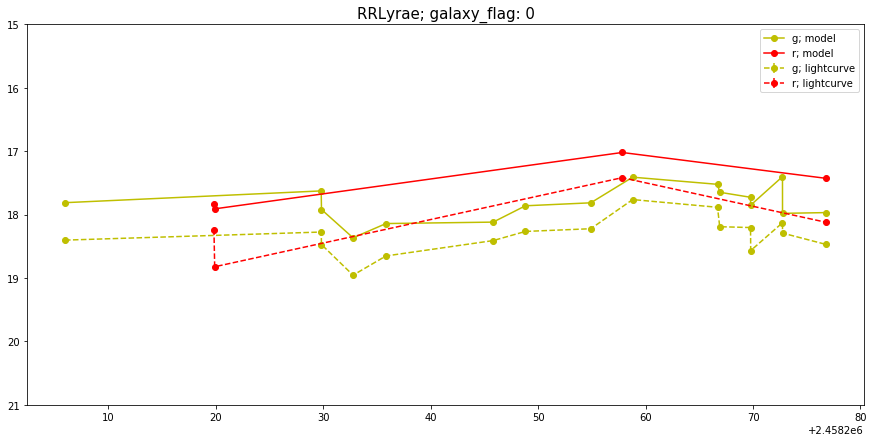

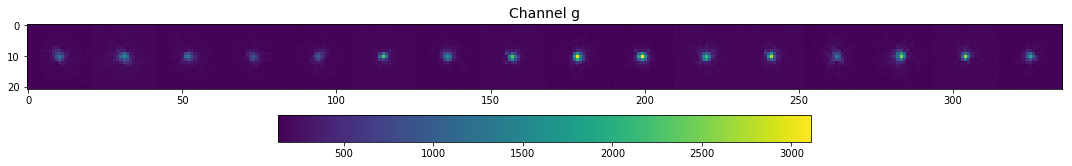

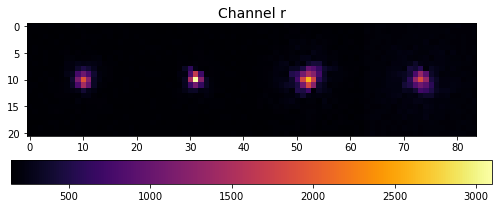


Field03
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 17) r: (60, 21, 21, 19)
g: (60, 17) r: (60, 19)
[236.8753  237.78432 237.83475 237.76324 237.73877 237.99245 237.82133
 237.88097 238.21817 237.98808 236.98917 237.92802 237.56378 237.77472
 237.44331 237.66829 237.59254 237.66113 237.63246]
obs days <HDF5 dataset "g": shape (17,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 17), type "<f8">
obs days <HDF5 dataset "r": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 17), type "<f8">

Field04
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 5) r: (60, 21, 21, 25)
g: (60, 5) r: (60, 25)
[238.40395 241.09995 241.03767 241.30412 241.16982 238.2321  238.26552
 24

/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


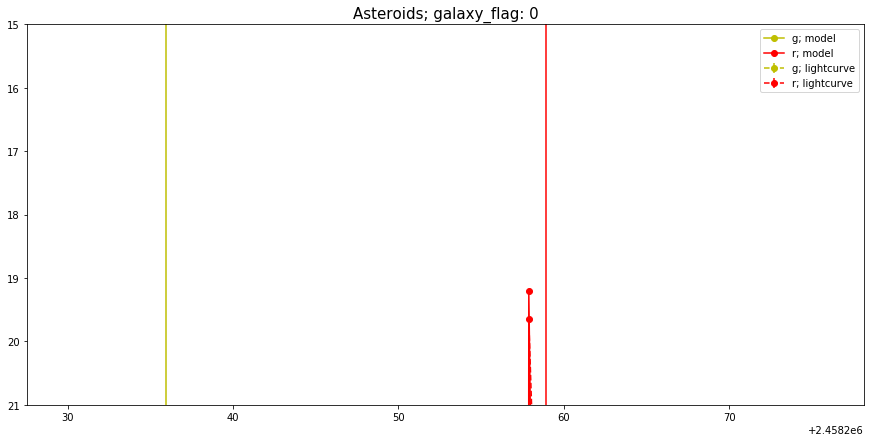

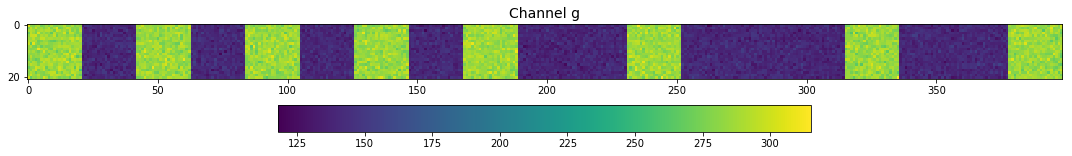

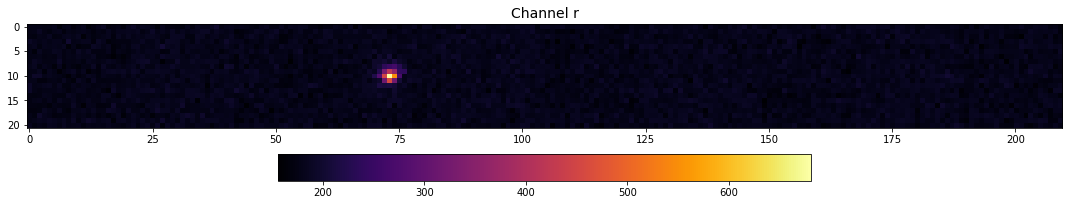


Field06
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 105) r: (60, 21, 21, 14)
g: (60, 105) r: (60, 14)
[292.50537 275.12805 275.12613 275.97244 171.21205 170.71794 170.93166
 171.09924 171.36568 276.1215  171.26653 169.43843 275.80444 170.87181]
obs days <HDF5 dataset "g": shape (105,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 105), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field06[34]


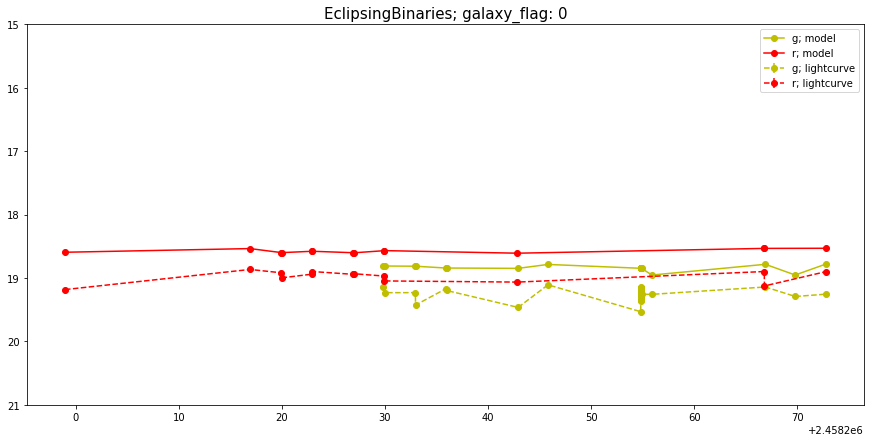

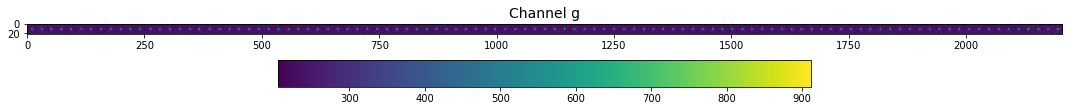

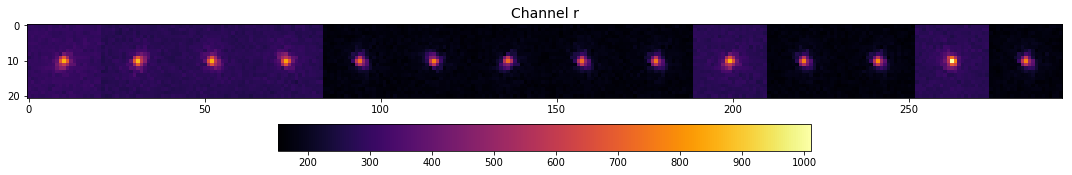


Field07
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 91) r: (60, 21, 21, 8)
g: (60, 91) r: (60, 8)
[170.49988 171.22375 170.49419 171.60219 170.4996  171.67415 170.45094
 171.46553]
obs days <HDF5 dataset "g": shape (91,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 91), type "<f8">
obs days <HDF5 dataset "r": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">
Field07[52]


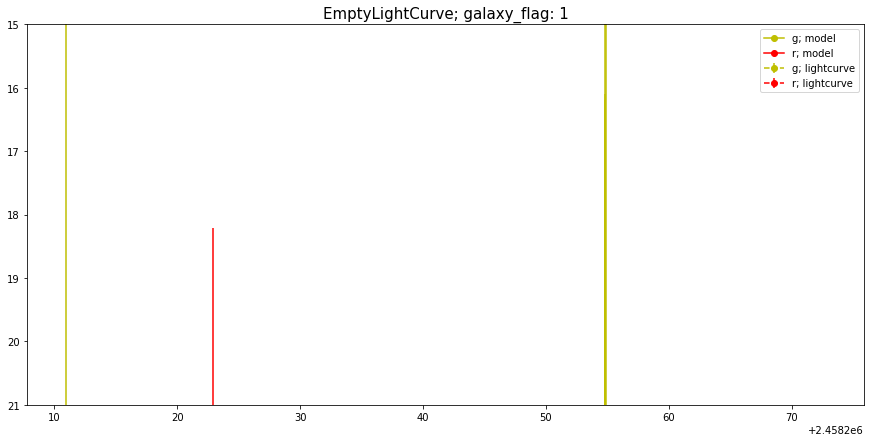

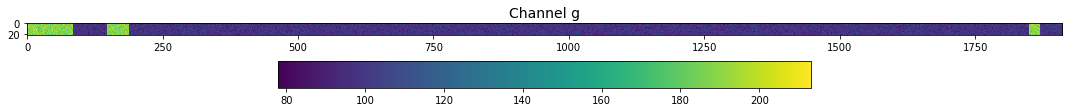

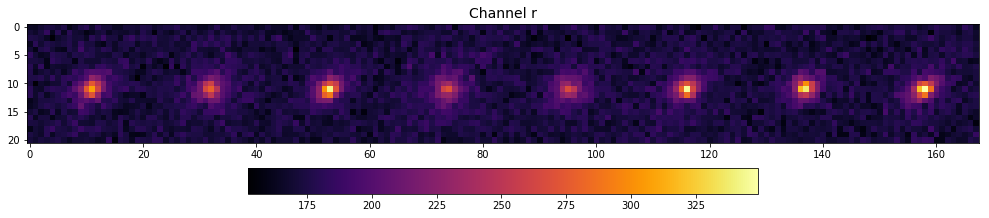


Field08
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 11) r: (60, 21, 21, 20)
g: (60, 11) r: (60, 20)
[215.59013 213.5351  216.80724 213.803   214.68864 216.69653 213.0752
 213.69807 214.47964 213.71774 217.21391 212.95915 213.0352  212.78474
 212.96625 213.75558 215.06757 214.28317 213.68771 213.0656 ]
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field09
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 13) r: (60, 21, 21, 11)
g: (60, 13) r: (60, 11)
[171.51163 171.71243 171.69823 171.52438 171.49094 171.71149 17

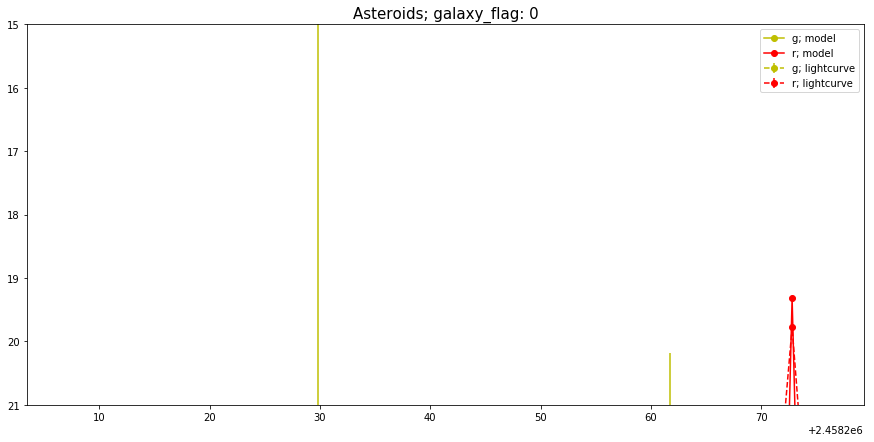

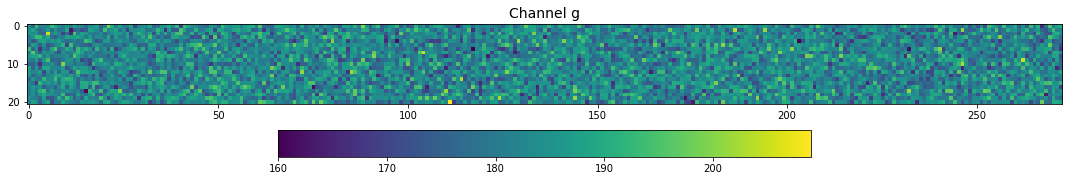

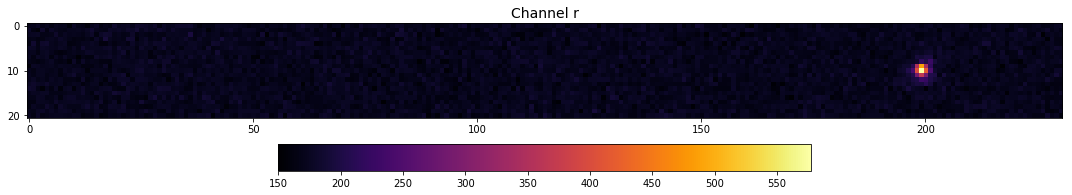


Field10
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 20) r: (60, 21, 21, 14)
g: (60, 20) r: (60, 14)
[175.20972 161.13667 161.1323  175.2914  175.20363 175.0104  175.17175
 175.1675  175.17981 175.317   175.11809 175.05933 175.25165 175.65176]
obs days <HDF5 dataset "g": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 20), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field10[20]


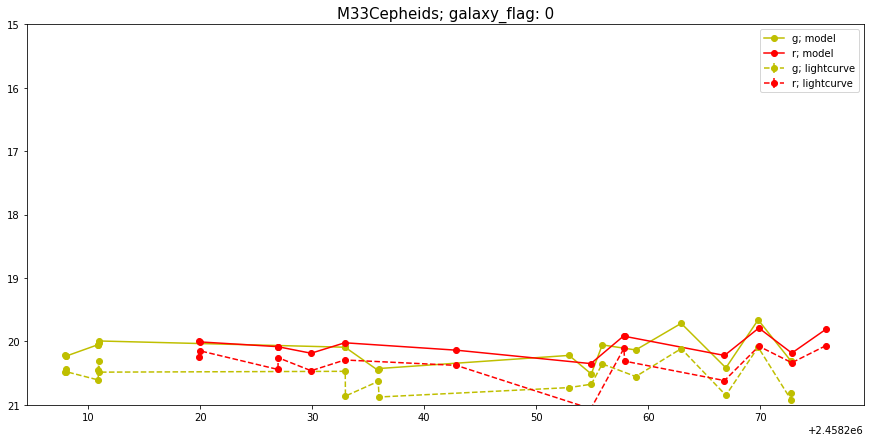

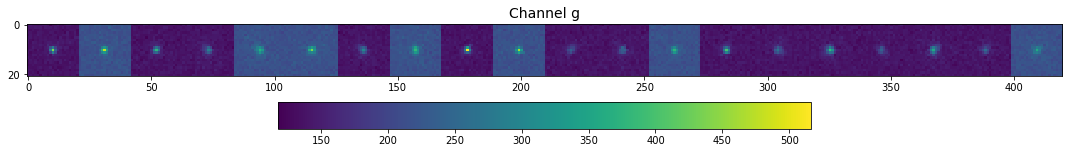

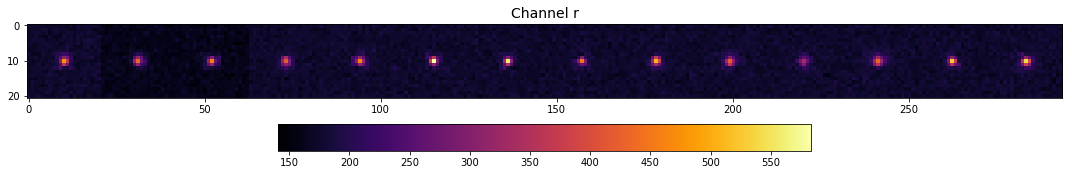


Field11
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 13) r: (60, 21, 21, 7)
g: (60, 13) r: (60, 7)
[186.07216 185.86557 185.8169  185.92093 186.08856 186.06924 185.5621 ]
obs days <HDF5 dataset "g": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 13), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field11[39]


/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


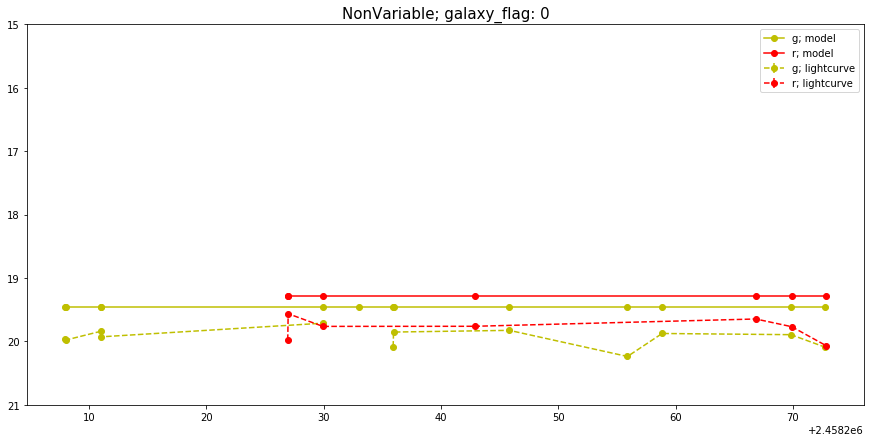

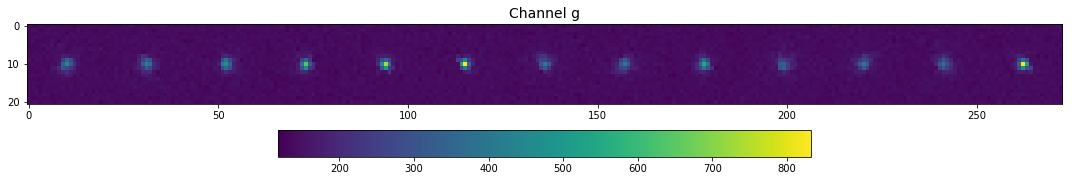

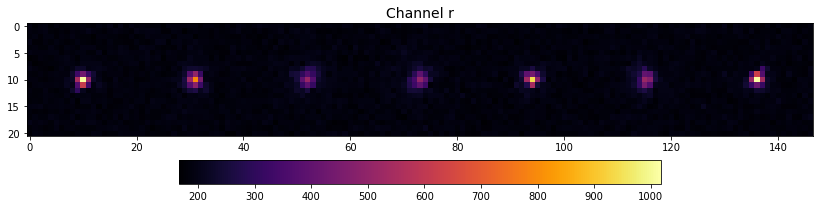


Field12
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 19) r: (60, 21, 21, 22)
g: (60, 19) r: (60, 22)
[228.1752  264.81873 264.79416 228.78894 264.8034  228.57896 264.72162
 228.44156 264.7922  264.7284  264.79123 228.27905 229.19078 228.50258
 264.86108 228.30576 264.87378 230.43776 265.92163 229.20326 228.84172
 264.84833]
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (22,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 19), type "<f8">

Field13
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 7) r: (60, 21, 21, 16)
g: (60, 7) r: (60, 16)
[239.39262 236.88585 238.47244 240.06488 24

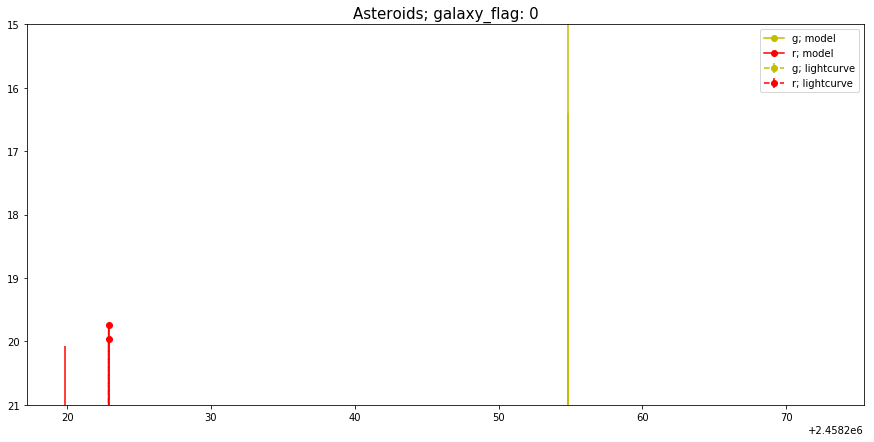

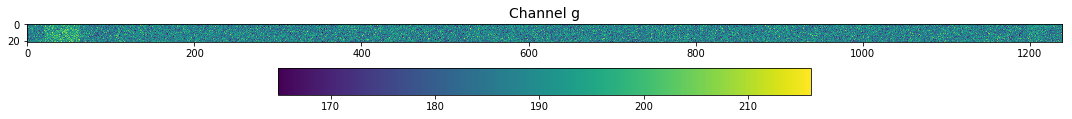

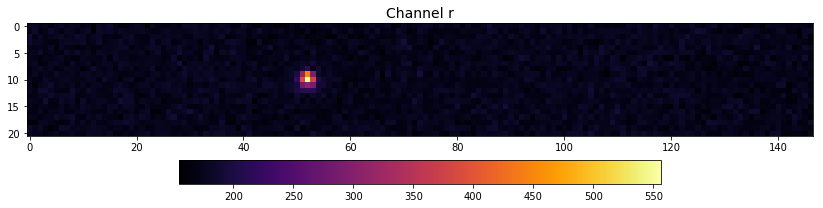


Field18
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 19) r: (60, 21, 21, 1)
g: (60, 19) r: (60, 1)
[263.20258]
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (1,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 1), type "<f8">
Field18[34]


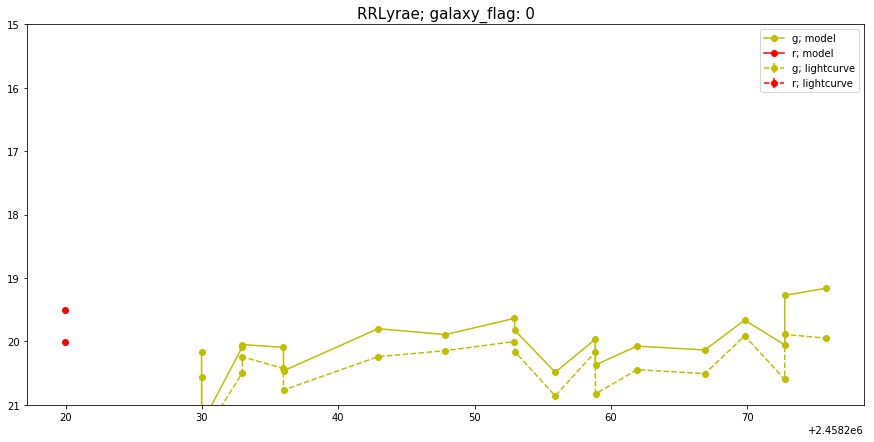

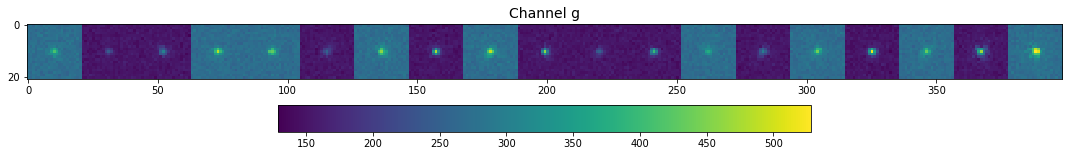

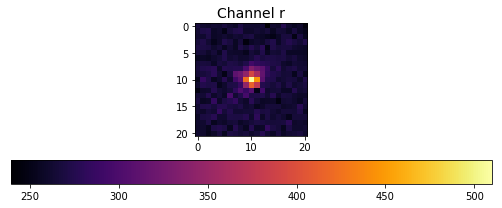


Field19
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 15) r: (60, 21, 21, 9)
g: (60, 15) r: (60, 9)
[216.45549 230.38727 216.38994 230.58792 229.54367 229.8385  215.59769
 230.0752  216.24626]
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (9,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 9), type "<f8">
Field19[37]


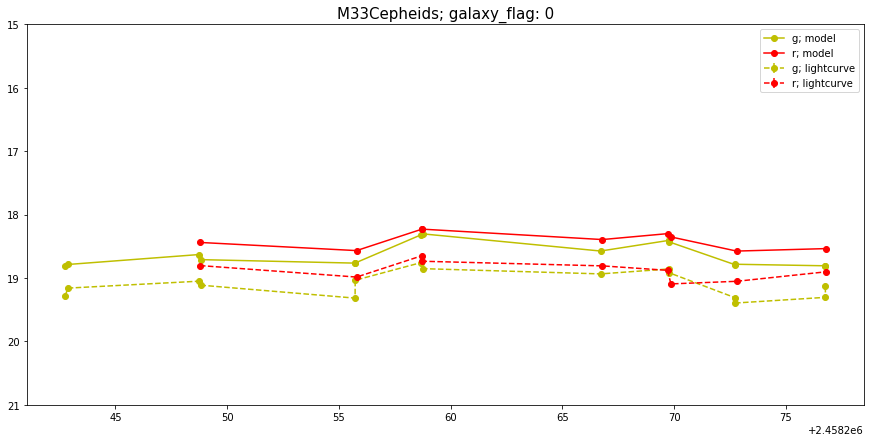

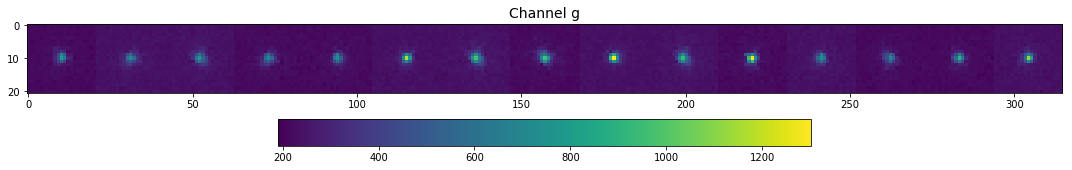

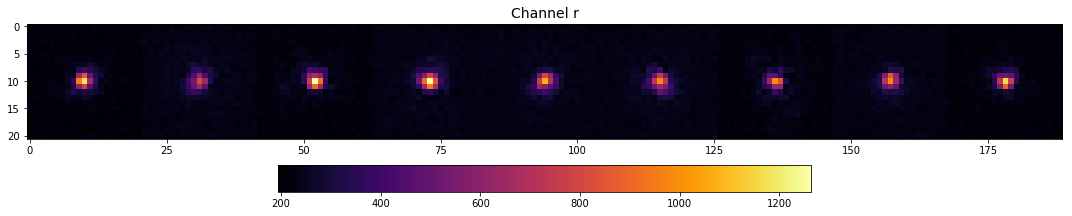


Field20
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 14) r: (60, 21, 21, 16)
g: (60, 14) r: (60, 16)
[178.50563 220.0772  178.57423 178.87852 220.08238 178.9041  178.77821
 219.95164 178.61523 219.62578 178.44273 178.67299 178.56978 178.85117
 220.0379  219.68211]
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">

Field21
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 21) r: (60, 21, 21, 15)
g: (60, 21) r: (60, 15)
[166.18913 165.89172 165.96735 179.64674 166.14053 179.41672 166.45381
 179.60919 166.15494 165.11382 

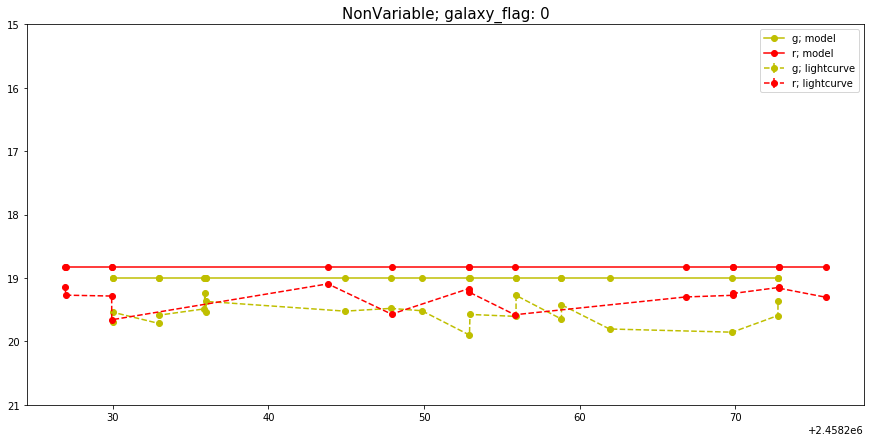

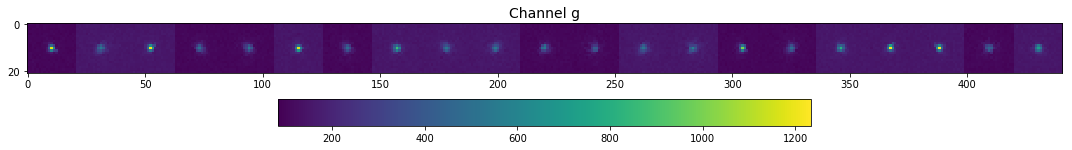

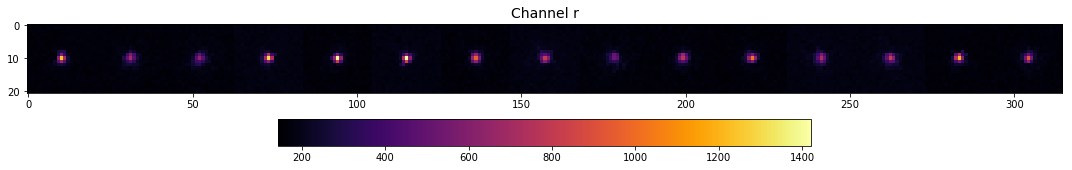


Field22
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 11) r: (60, 21, 21, 13)
g: (60, 11) r: (60, 13)
[224.19814 224.06923 224.191   224.14847 166.25615 224.25273 224.41464
 166.40825 224.41467 165.75871 166.18375 223.97679 224.35349]
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field23
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 28) r: (60, 21, 21, 14)
g: (60, 28) r: (60, 14)
[166.94434 168.79381 168.76418 166.88527 166.80072 166.98665 168.51732
 168.31505 166.9571  168.57089 167.17688 166.71762 166.77196 1

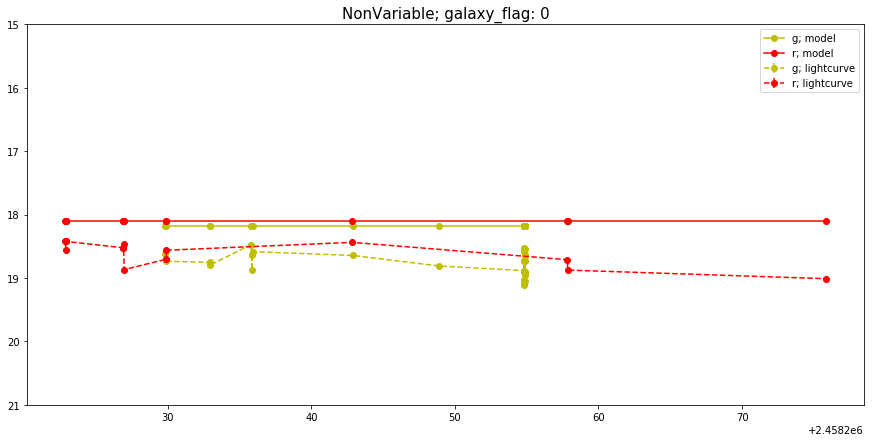

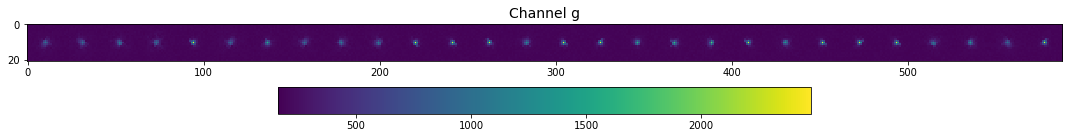

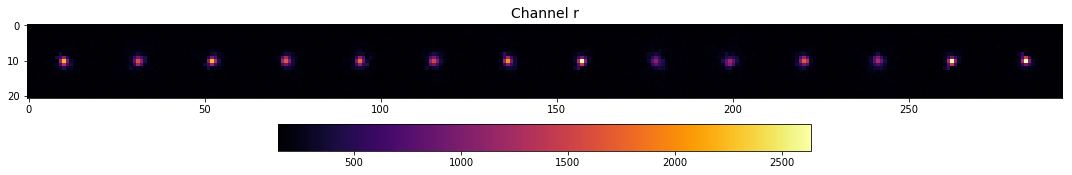


Field24
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 98) r: (60, 21, 21, 2)
g: (60, 98) r: (60, 2)
[171.48814 171.43246]
obs days <HDF5 dataset "g": shape (98,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 98), type "<f8">
obs days <HDF5 dataset "r": shape (2,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 2), type "<f8">
Field24[16]


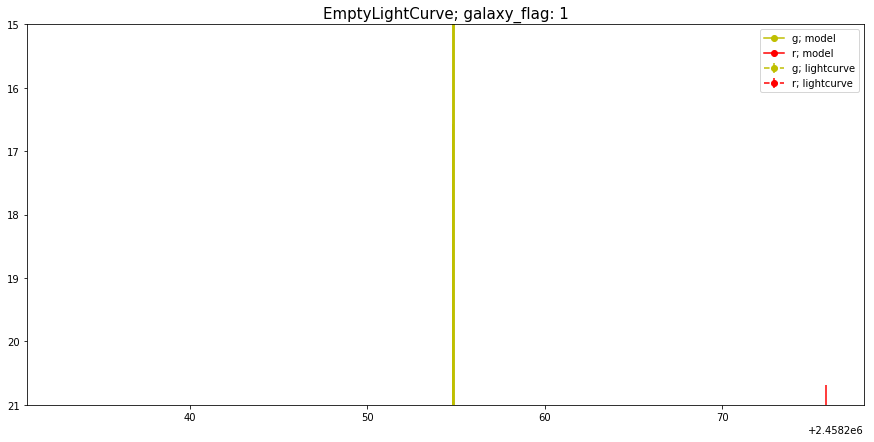

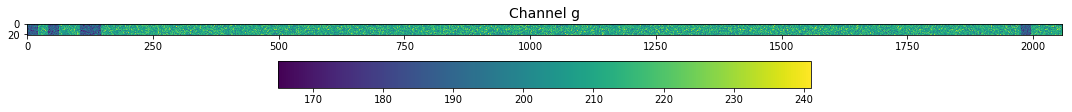

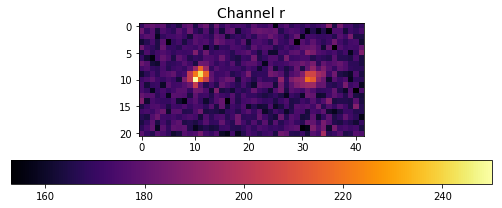


Field25
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 4) r: (60, 21, 21, 20)
g: (60, 4) r: (60, 20)
[208.1373  208.03398 208.0395  224.11058 221.1571  203.60284 224.50003
 224.51776 203.63606 207.87093 224.63013 208.0363  224.39812 224.31033
 223.56625 224.14326 208.02795 224.3869  207.89148 224.64323]
obs days <HDF5 dataset "g": shape (4,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 4), type "<f8">
obs days <HDF5 dataset "r": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 4), type "<f8">

Field26
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 22) r: (60, 21, 21, 19)
g: (60, 22) r: (60, 19)
[210.952   210.91013 216.33398 211.2897  235.70828 235.82458 211.17

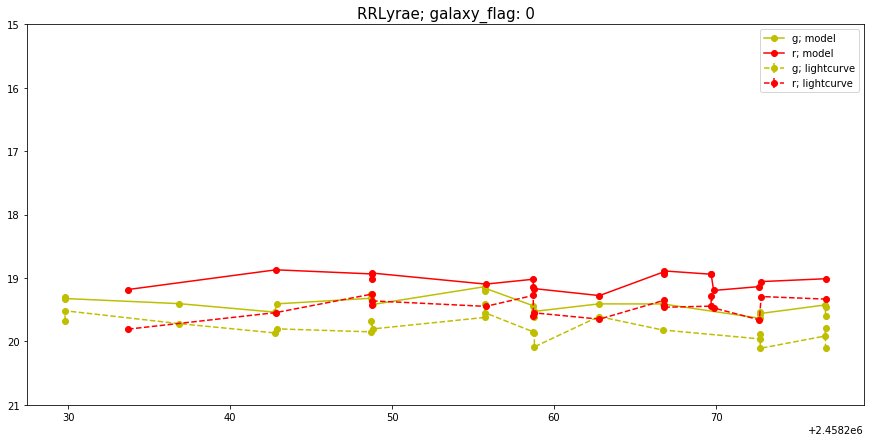

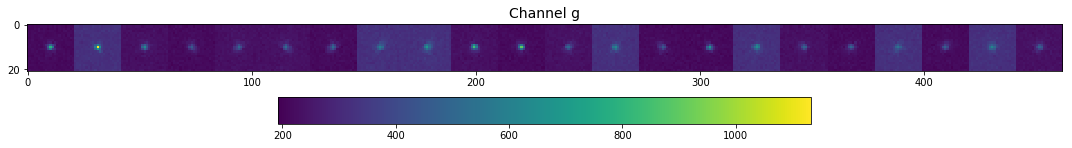

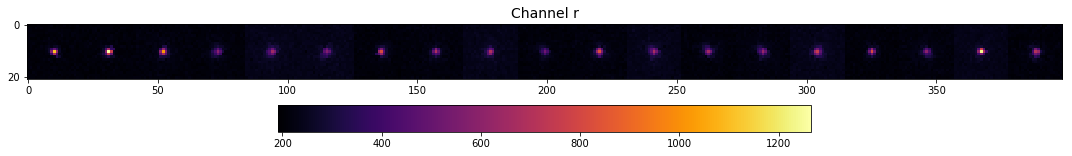


Field27
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 94) r: (60, 21, 21, 5)
g: (60, 94) r: (60, 5)
[168.02678 167.986   168.0893  168.1269  168.02448]
obs days <HDF5 dataset "g": shape (94,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 94), type "<f8">
obs days <HDF5 dataset "r": shape (5,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 5), type "<f8">
Field27[50]


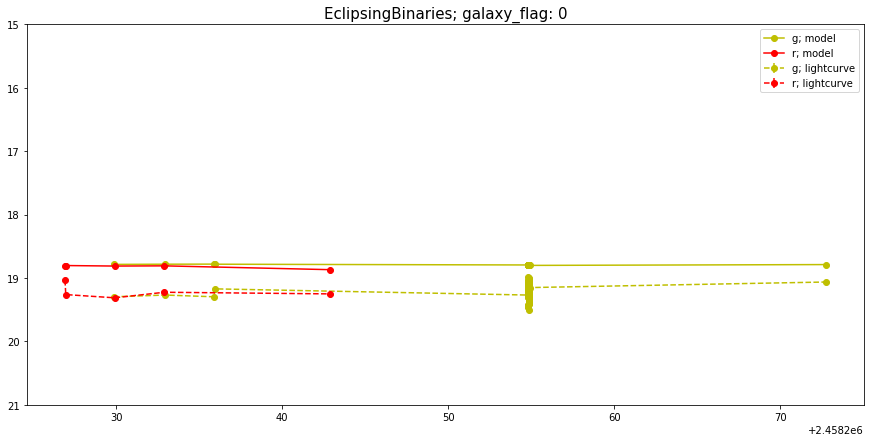

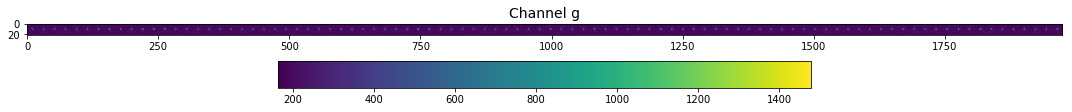

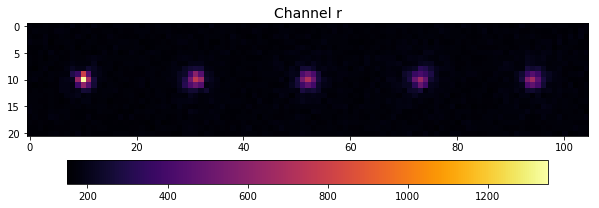


Field28
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 10) r: (60, 21, 21, 10)
g: (60, 10) r: (60, 10)
[224.03055 224.02168 224.042   223.99136 223.90125 224.13176 224.00594
 224.3214  223.51749 223.89307]
obs days <HDF5 dataset "g": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 10), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field28[2]


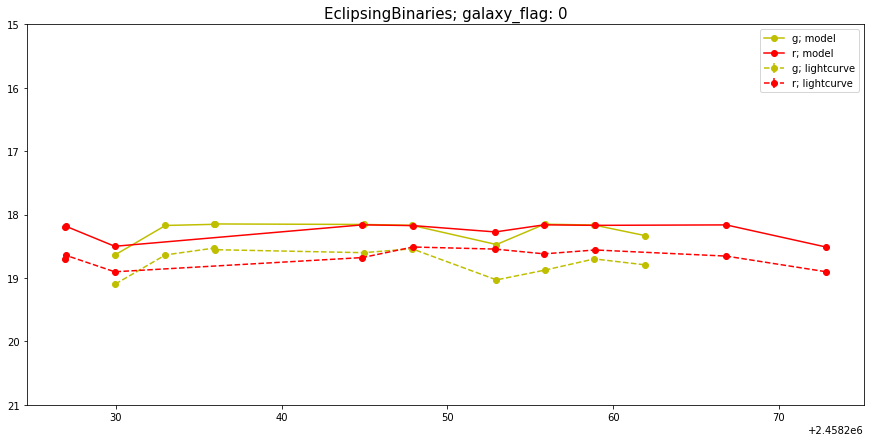

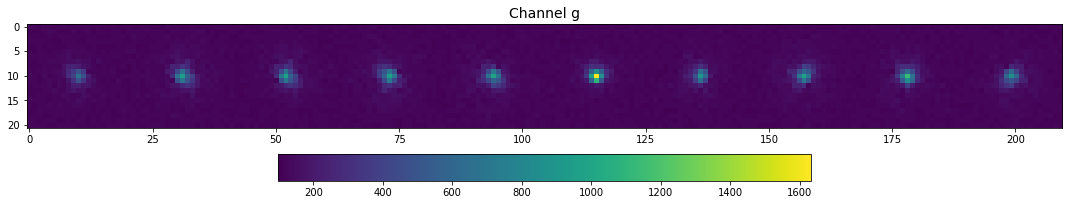

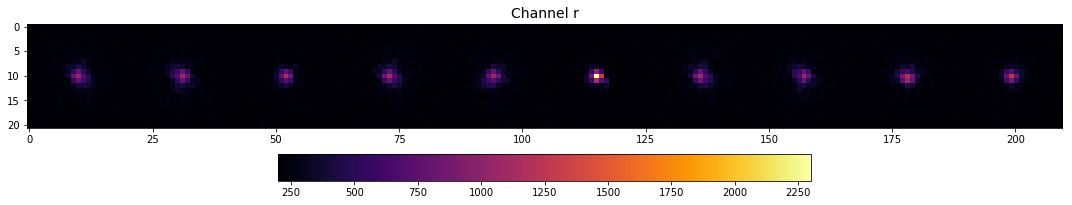


Field29
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 87) r: (60, 21, 21, 2)
g: (60, 87) r: (60, 2)
[151.87144 151.78528]
obs days <HDF5 dataset "g": shape (87,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 87), type "<f8">
obs days <HDF5 dataset "r": shape (2,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 2), type "<f8">
Field29[53]


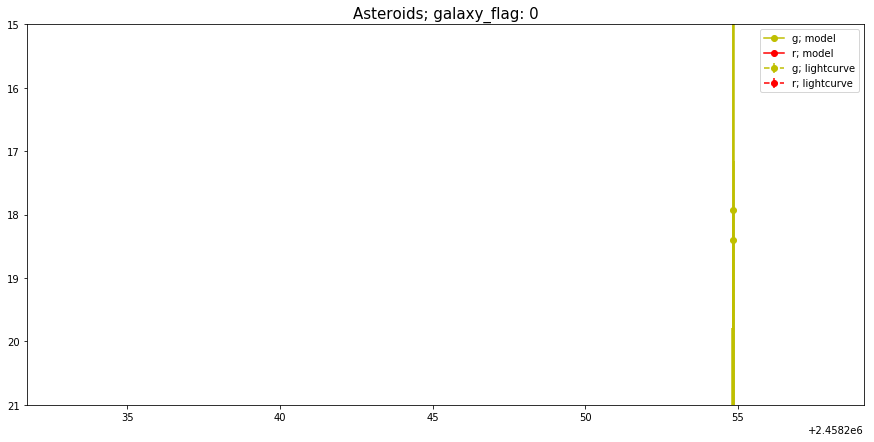

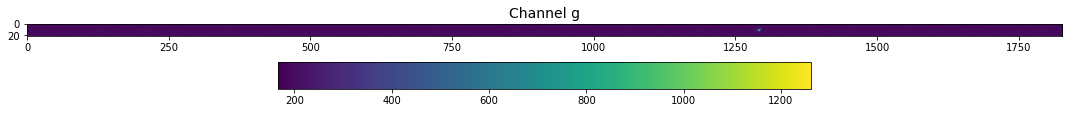

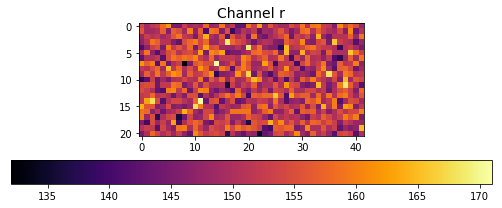


Field30
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 8) r: (60, 21, 21, 13)
g: (60, 8) r: (60, 13)
[202.55403 203.13106 158.304   203.00378 202.95795 158.30766 158.4721
 203.00395 202.78775 201.53018 158.45204 202.8704  203.05908]
obs days <HDF5 dataset "g": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 8), type "<f8">
obs days <HDF5 dataset "r": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">

Field32
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 17) r: (60, 21, 21, 15)
g: (60, 17) r: (60, 15)
[277.70856 277.9187  279.22714 278.8441  278.5239  279.26083 304.06308
 278.99304 278.12125 279.49738 279.39093 278.6699  277.6441  278.145

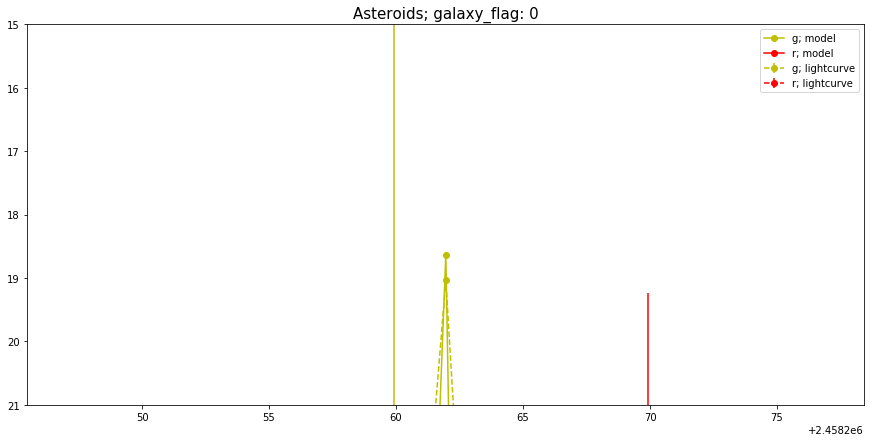

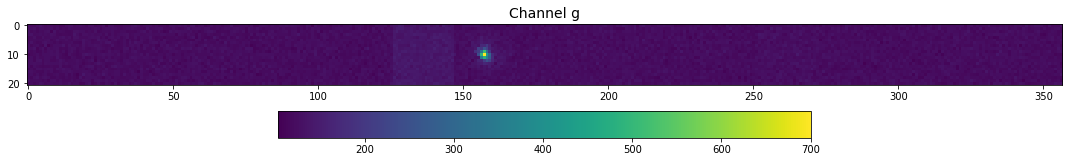

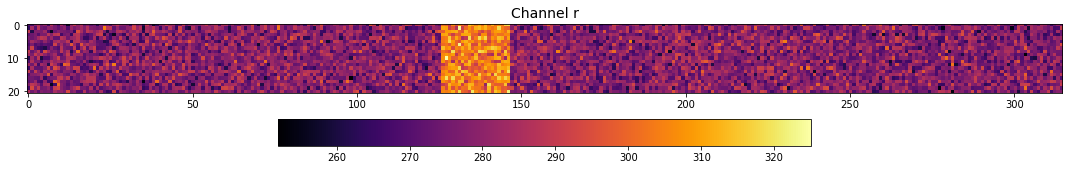


Field33
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 14) r: (60, 21, 21, 7)
g: (60, 14) r: (60, 7)
[294.039   294.80795 294.90683 294.551   294.34158 186.11531 186.09286]
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field33[16]


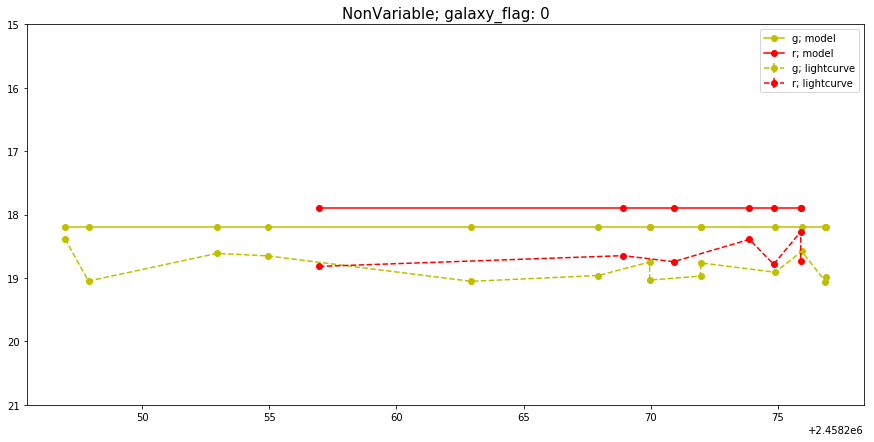

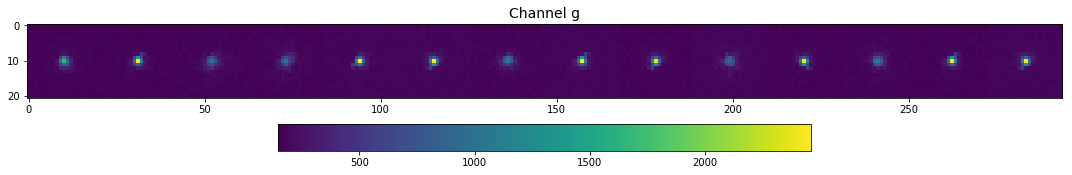

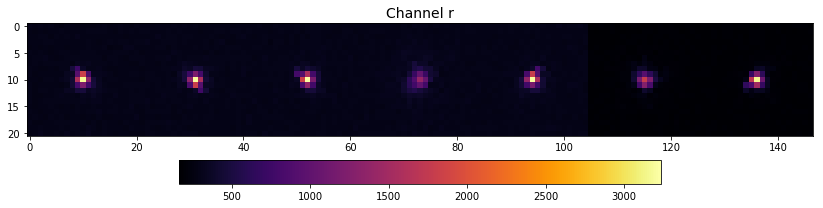


Field34
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 15) r: (60, 21, 21, 10)
g: (60, 15) r: (60, 10)
[242.05974 286.06158 286.1049  241.95972 241.56502 240.91942 286.30643
 286.28085 241.56686 242.62547]
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field34[44]


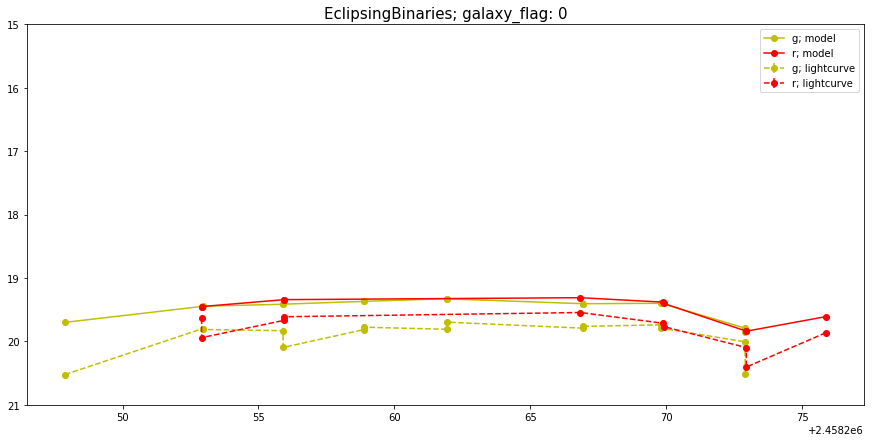

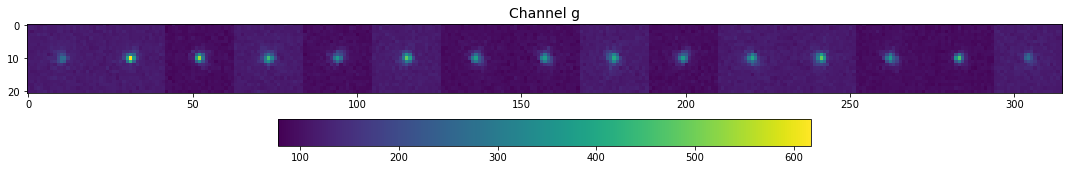

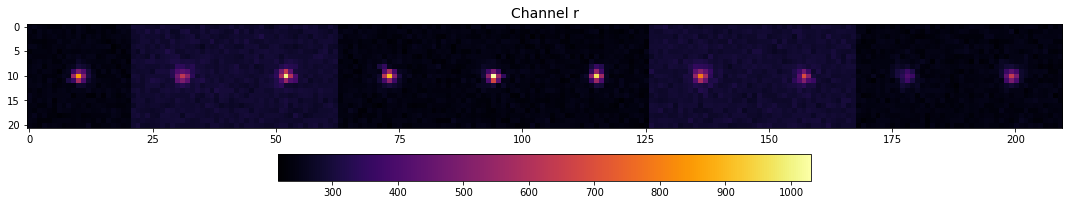


Field35
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 24) r: (60, 21, 21, 1)
g: (60, 24) r: (60, 1)
[232.99545]
obs days <HDF5 dataset "g": shape (24,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 24), type "<f8">
obs days <HDF5 dataset "r": shape (1,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 1), type "<f8">
Field35[39]


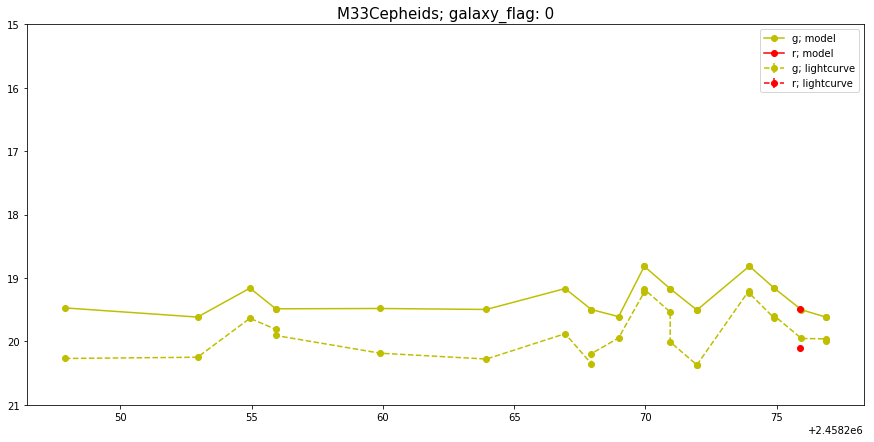

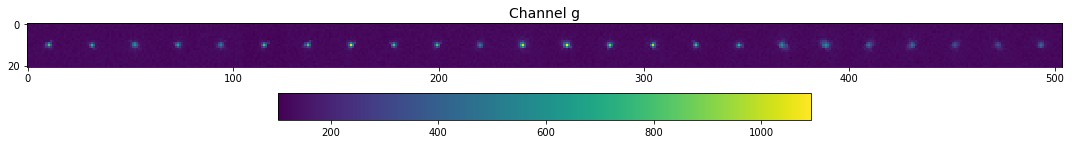

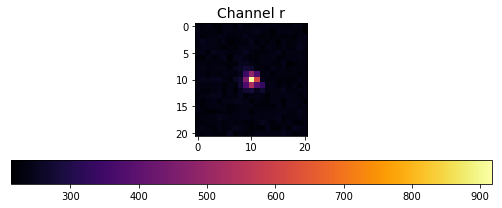


Field36
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 14) r: (60, 21, 21, 12)
g: (60, 14) r: (60, 12)
[251.88396 222.49445 251.9355  222.51624 251.88654 251.8511  221.8162
 222.42984 251.90373 222.41162 251.77751 222.61952]
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 12), type "<f8">
Field36[36]


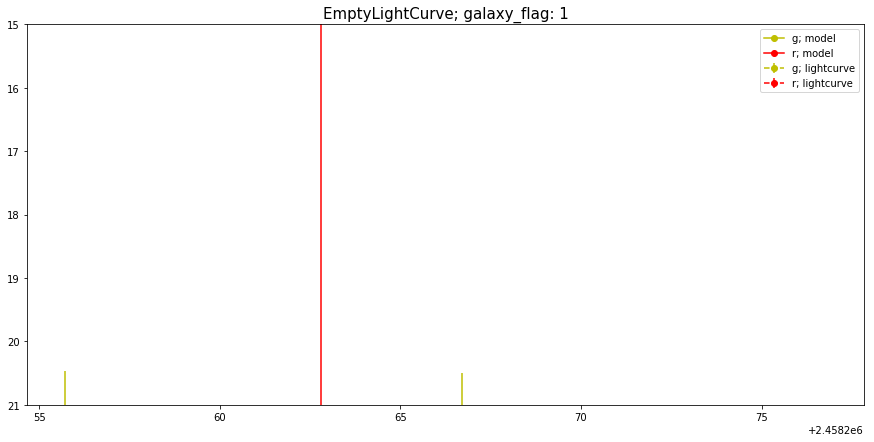

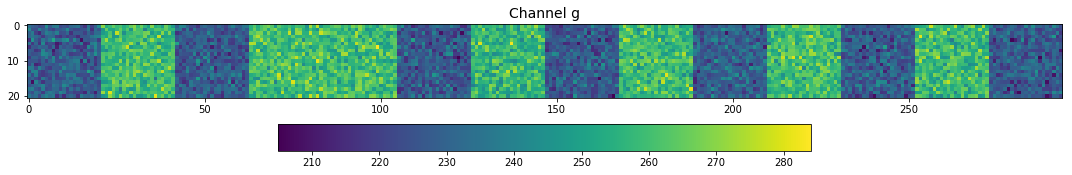

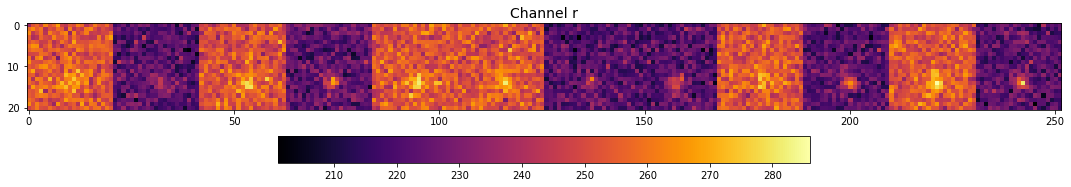


Field38
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 14) r: (60, 21, 21, 11)
g: (60, 14) r: (60, 11)
[179.13025 178.79419 310.04184 309.74796 178.42418 178.46158 178.59325
 310.38785 179.25893 309.98233 310.10886]
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">
Field38[23]


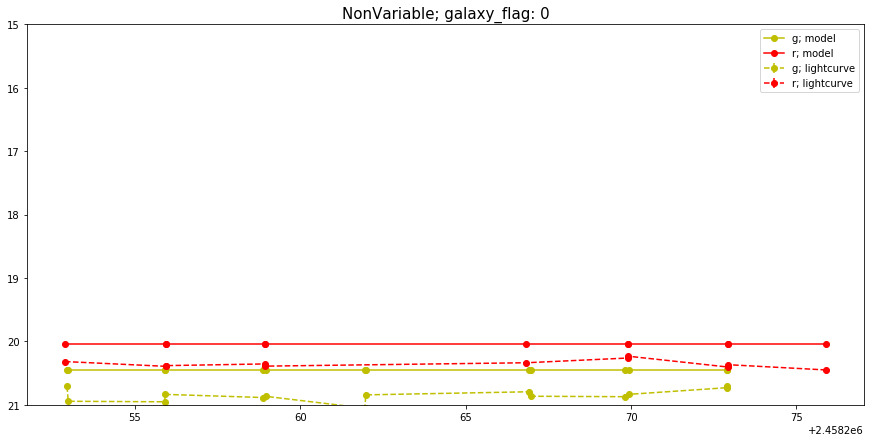

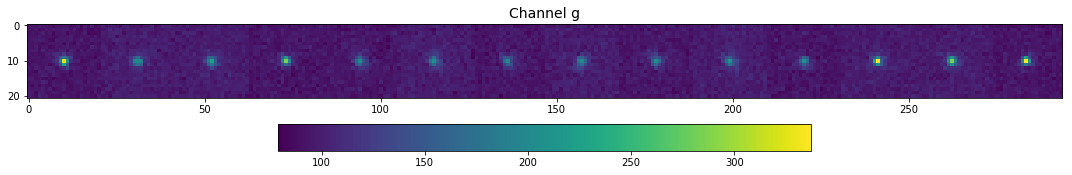

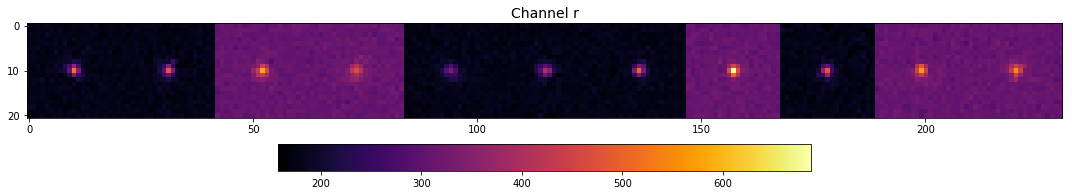


Field39
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 27) r: (60, 21, 21, 16)
g: (60, 27) r: (60, 16)
[296.6732  296.73193 296.47165 296.5877  296.36438 297.71362 297.81772
 302.61798 297.63535 296.81046 298.22806 297.81058 297.08783 297.06308
 296.4089  296.90463]
obs days <HDF5 dataset "g": shape (27,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 27), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 16), type "<f8">
Field39[8]


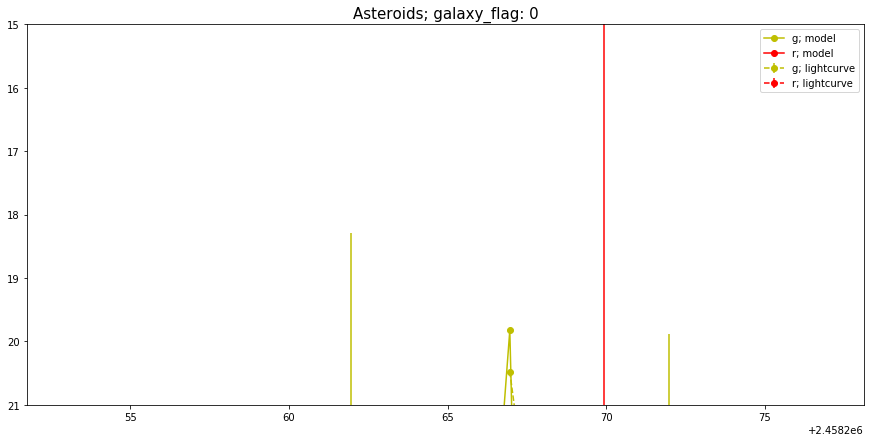

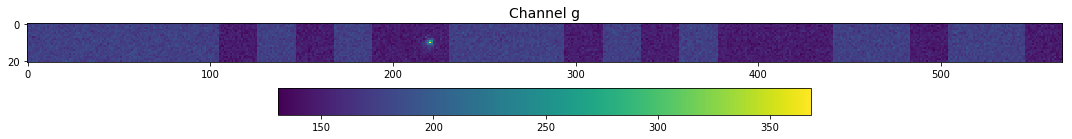

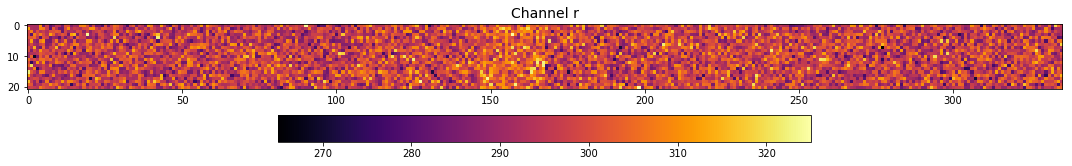


Field40
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 15) r: (60, 21, 21, 8)
g: (60, 15) r: (60, 8)
[176.31895 177.72433 177.14813 178.22185 177.71005 177.04543 177.48357
 176.79196]
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">
Field40[37]


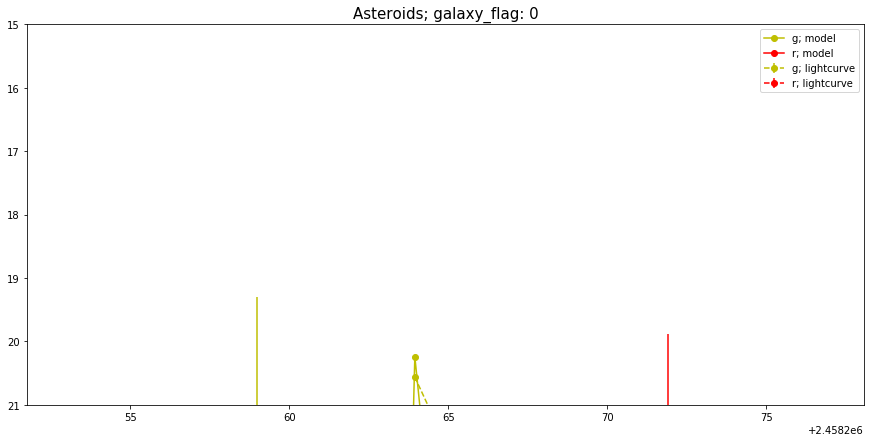

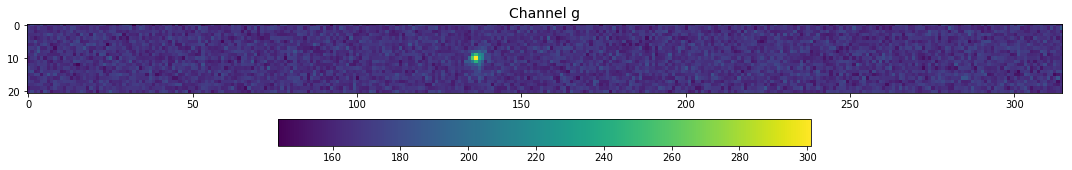

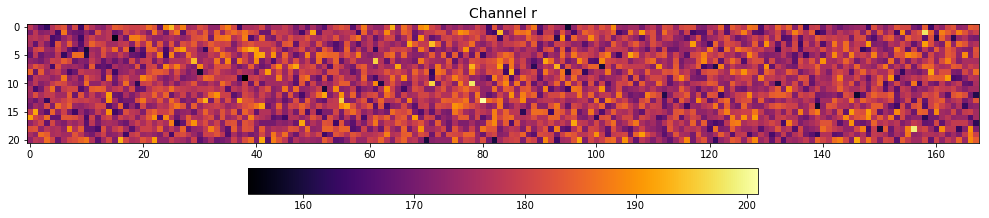


Field41
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 3) r: (60, 21, 21, 23)
g: (60, 3) r: (60, 23)
[294.7136  294.28137 294.57724 294.47745 294.16623 195.47221 294.3428
 194.94096 195.48029 294.17593 294.46646 195.3723  195.07854 293.3617
 294.54852 294.90585 195.93782 294.5536  195.67523 295.2339  195.4439
 294.77316 294.5044 ]
obs days <HDF5 dataset "g": shape (3,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 3), type "<f8">
obs days <HDF5 dataset "r": shape (23,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 3), type "<f8">

Field43
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 11) r: (60, 21, 21, 15)
g: (60, 11) r: (60, 15)
[287.30222 287.31238 287.18903 287.4881

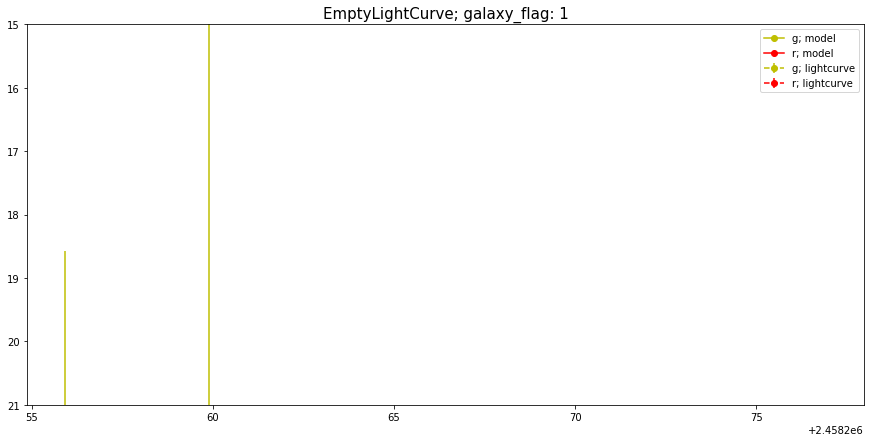

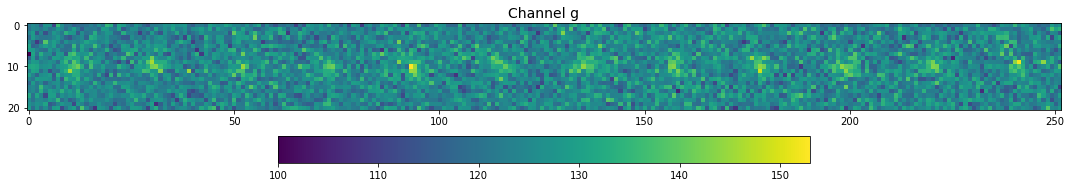

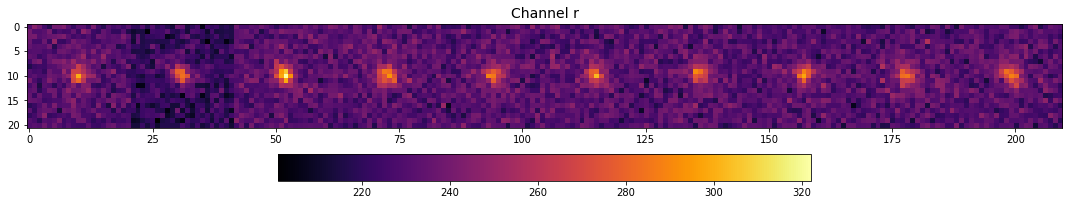

In [110]:
bands = ["g", "r"]
n_per_field = 3
for field in fields:
    print('\n%s' % (field))
    #if field in ['Field01', 'Field03', 'Field04', 'Field08', 'Field12']:
    #    continue
    field_data = f[field]
    print(list(field_data))
    field_images = field_data["images"]
    print("g:", field_images["g"].shape, "r:", field_images["r"].shape)
    field_lc = field_data["lightcurves"]
    print("g:", field_lc["g"].shape, "r:", field_lc["r"].shape)
    days = field_data["obs_cond"]["obs_day"]
    print(field_data["obs_cond"]["sky_brightness"]["r"][:])
    
    for band in bands:
        print('obs days %s' % str(days[band]))
        print('estimated_counts %s' % str(field_data['estimated_counts'][band]))
    if  days[bands[1]].shape[0]!=field_data['estimated_counts'][bands[1]].shape[1]:
        continue
    idx = plot_underliying_and_lc_model(f, field=field)
    lc_type = field_data["lc_type"][idx]
    
    """
    plt.figure(figsize=(15, 7))
    for band in bands:
        plt.plot(days[band], field_lc[band][0, ...], "o-", label=band)
    galaxy_flag = field_data["galaxy_flag"][0]
    plt.title(lc_type+" galaxy_flag", fontsize=15)
    plt.ylim([21, 15])
    plt.legend()
    plt.show()
    """
    for band in bands:
        n_images = field_lc[band].shape[1]
        plt.figure(figsize=(15,3))#3*n_images,3))
        empty_image = np.zeros((21, 21*n_images,))
        for i in range(n_images):
            empty_image[:, i*21:(i+1)*21] = field_images[band][idx, :, :, i]
        if band == "g":
            c_map = "viridis"
        else:
            c_map = "inferno"
        plt.imshow(empty_image, cmap=c_map)
        plt.title('Channel %s' % band, fontsize=14)#np.amin(empty_image))
        plt.colorbar(orientation="horizontal")
        plt.tight_layout()
        plt.show()